# NOAA Historical Weather Station Data
https://registry.opendata.aws/noaa-isd/

The Integrated Surface Database (ISD) from the United States National Oceanic and Atmospheric Administration (NOAA) consists of global hourly and synoptic observations compiled from numerous sources into a gzipped fixed width format. The data format is described [here](https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf). They also have conveniently converted all of this gzipped, fixed-width data into csv files and host it on an open S3 bucket (`arn:aws:s3:::noaa-global-hourly-pds`). You can [browse the bucket here](https://noaa-global-hourly-pds.s3.amazonaws.com/index.html). The data is also on this [ftp site](https://www1.ncdc.noaa.gov/pub/data/noaa/). This site contains other useful files as well like a [csv file with all the station IDs, locations, and record date ranges](https://www1.ncdc.noaa.gov/pub/data/noaa/isd-history.csv).

In this notebook I will explore the data source by extracting the temperature and dew point data recorded at Centennial Airport in Colorado during 2021.

First, download the csv with station metadata.

In [ ]:
!wget https://noaa-isd-pds.s3.amazonaws.com/isd-history.csv -O isd-stations.csv

Read in the data from the csv, while parsing the correct data types, and merging the `USAF` and `WBAN` together for a single, combined ID

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

isd_stations = (pd.read_csv('isd-stations.csv',
                            parse_dates=['BEGIN', 'END'], 
                            dtype={'USAF': str, 'WBAN': str}
                            )
                .assign(station_id=lambda df_: df_['USAF'] + df_['WBAN'])
)

isd_stations.info()
isd_stations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29606 entries, 0 to 29605
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   USAF          29606 non-null  object        
 1   WBAN          29606 non-null  object        
 2   STATION NAME  28816 non-null  object        
 3   CTRY          28711 non-null  object        
 4   STATE         6618 non-null   object        
 5   ICAO          10797 non-null  object        
 6   LAT           28420 non-null  float64       
 7   LON           28419 non-null  float64       
 8   ELEV(M)       28316 non-null  float64       
 9   BEGIN         29606 non-null  datetime64[ns]
 10  END           29606 non-null  datetime64[ns]
 11  station_id    29606 non-null  object        
dtypes: datetime64[ns](2), float64(3), object(7)
memory usage: 2.7+ MB


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,station_id
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.00,0.000,7018.0,2011-03-09,2013-07-30,00701899999
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.00,0.000,7026.0,2012-07-13,2017-08-22,00702699999
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.00,0.000,7070.0,2014-09-23,2015-09-26,00707099999
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.00,0.000,0.0,2005-01-01,2012-07-31,00826099999
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.95,65.567,1156.7,2010-05-19,2012-03-23,00826899999


Filter the data to all stations in Colorado that have data from 2022 and have the word `AIRPORT` in the name.

In [63]:
(isd_stations[ (isd_stations['STATE']=='CO') & 
               (isd_stations['END'] > '2022') & 
               (isd_stations['STATION NAME'].str.contains('AIRPORT'))
            ]
            .sort_values(by=['END', 'STATION NAME'], ascending=[False, True])
            .head(100)
)

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,station_id
17454,720535,00162,FORT MORGAN MUNICIPAL AIRPORT,US,CO,KFMM,40.333,-103.800,1393.2,2012-07-26,2022-03-05,72053500162
17456,720537,00163,HOLYOKE AIRPORT,US,CO,KHEQ,40.567,-102.267,1137.2,2010-11-29,2022-03-05,72053700163
17465,720544,00168,STERLING MUNICIPAL AIRPORT,US,CO,KSTK,40.617,-103.267,1231.1,2010-11-29,2022-03-05,72054400168
17449,720531,00158,BLAKE FIELD AIRPORT,US,CO,KAJZ,38.783,-108.067,1583.1,2012-02-09,2022-03-04,72053100158
17451,720533,00160,BOULDER MUNICIPAL AIRPORT,US,CO,KBDU,40.033,-105.217,1612.1,2010-02-01,2022-03-04,72053300160
19600,724680,94015,BUTTS AAF AIRPORT,US,CO,KFCS,38.678,-104.757,1779.4,1966-09-15,2022-03-04,72468094015
19583,724666,93067,CENTENNIAL AIRPORT,US,CO,KAPA,39.560,-104.848,1789.2,2006-01-01,2022-03-04,72466693067
19648,724767,93069,CORTEZ MUNICIPAL AIRPORT,US,CO,KCEZ,37.307,-108.626,1799.2,2006-01-01,2022-03-04,72476793069
20269,725700,24046,CRAIG-MOFFAT AIRPORT,US,CO,KCAG,40.493,-107.524,1884.9,2006-01-01,2022-03-04,72570024046
20258,725650,03017,DENVER INTERNATIONAL AIRPORT,US,CO,KDEN,39.847,-104.656,1647.2,1994-07-18,2022-03-04,72565003017


I want to get the data for the Centennial Airport, so I will use `station_id = 72466693067`

In [120]:
URL_BASE = 'https://noaa-global-hourly-pds.s3.amazonaws.com'
year = 2021
station_id = '72466693067'
csv_path = f'{URL_BASE}/{year}/{station_id}.csv'

station_data = pd.read_csv(csv_path)
station_data.head()

/home/michael/miniconda3/envs/general/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (18,38,39,43,48,49,52,53,86) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,...,MW1,MW2,OC1,OD1,OE1,OE2,OE3,WA1,REM,EQD
0,72466693067,2021-01-01T00:53:00,7,39.5599,-104.84843,1789.2,"DENVER CENTENNIAL AIRPORT, CO US",FM-15,KAPA,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET10012/31/20 17:53:03 METAR KAPA 010053Z 010...,NaN
1,72466693067,2021-01-01T01:53:00,7,39.5599,-104.84843,1789.2,"DENVER CENTENNIAL AIRPORT, CO US",FM-15,KAPA,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET10012/31/20 18:53:03 METAR KAPA 010153Z 340...,NaN
2,72466693067,2021-01-01T02:53:00,7,39.5599,-104.84843,1789.2,"DENVER CENTENNIAL AIRPORT, CO US",FM-15,KAPA,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET11312/31/20 19:53:03 METAR KAPA 010253Z 320...,NaN
3,72466693067,2021-01-01T03:53:00,7,39.5599,-104.84843,1789.2,"DENVER CENTENNIAL AIRPORT, CO US",FM-15,KAPA,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET10812/31/20 20:53:03 METAR KAPA 010353Z 360...,NaN
4,72466693067,2021-01-01T04:53:00,7,39.5599,-104.84843,1789.2,"DENVER CENTENNIAL AIRPORT, CO US",FM-15,KAPA,V020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET10812/31/20 21:53:03 METAR KAPA 010453Z 000...,NaN


There are a lot of columns. I'm mostly interested in temperature and dew point, but they are in a strange format. According to the data format document, the values include the value in degrees celsius multiplied by 10 followed by a data quality flag separated by a comma. We will need to parse this out. 

In [121]:
station_data[['DATE', 'TMP', 'DEW']].head()

,DATE,TMP,DEW
0,2021-01-01T00:53:00,"+0017,5","-0067,5"
1,2021-01-01T01:53:00,"+0006,5","-0061,5"
2,2021-01-01T02:53:00,"+0006,5","-0083,5"
3,2021-01-01T03:53:00,"-0006,5","-0072,5"
4,2021-01-01T04:53:00,"-0017,5","-0078,5"


In [123]:
station_data[['temperature_degC', 'temperature_QC']] = station_data['TMP'].str.split(',', expand=True)
station_data[['dew_point_degC', 'dew_point_QC']] = station_data['DEW'].str.split(',', expand=True)

station_data = (station_data
                  .astype({'temperature_degC': float, 'dew_point_degC': float})
                  .assign(temperature_degC=lambda df_: (df_['temperature_degC'] / 10).replace(999.9, np.nan),
                          dew_point_degC=lambda df_: (df_['dew_point_degC'] / 10).replace(999.9, np.nan),
                  )
            )

In [124]:
station_data[['DATE', 'TMP', 'DEW', 'temperature_degC', 'dew_point_degC', 'temperature_QC', 'dew_point_QC']].head()

,DATE,TMP,DEW,temperature_degC,dew_point_degC,temperature_QC,dew_point_QC
0,2021-01-01T00:53:00,"+0017,5","-0067,5",1.7,-6.7,5,5
1,2021-01-01T01:53:00,"+0006,5","-0061,5",0.6,-6.1,5,5
2,2021-01-01T02:53:00,"+0006,5","-0083,5",0.6,-8.3,5,5
3,2021-01-01T03:53:00,"-0006,5","-0072,5",-0.6,-7.2,5,5
4,2021-01-01T04:53:00,"-0017,5","-0078,5",-1.7,-7.8,5,5


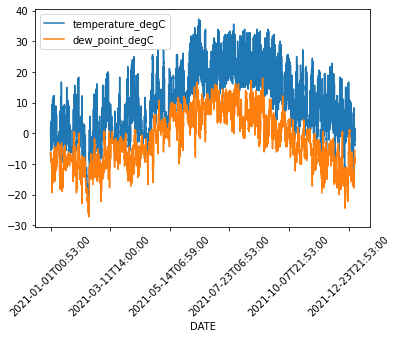

In [125]:
station_data.set_index('DATE')[['temperature_degC', 'dew_point_degC']].plot()
plt.xticks(rotation=45);